In [1]:
import os
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.ATLAS)
plt.rc('legend',fontsize='large')
plt.rc('axes',labelsize='x-large')
plt.rc('text',usetex='false')
plt.rc('xtick', labelsize='large')
from scipy.stats import wasserstein_distance
from itertools import combinations
from datetime import datetime
from packages.constants import VAR_INFOS_DTYPES
from packages.utils import get_electron_label, get_jet_label, get_logger

## Parameters

In [2]:
logger = get_logger('wass_distance', file=False)
basepath = os.path.join('..', '..')
datapath = os.path.join(basepath, 'data')
analysis_path =  os.path.join(basepath, 'analysis', 'wasserstein_shower_shapes')
var_info_path = os.path.join(datapath, 'var_infos.csv')
collision_path = os.path.join(datapath, 
    'ided_data17_13TeV.AllPeriods.sgn.probes_lhvloose_EGAM1.bkg.vprobes_vlhvloose_EGAM7.GRL_v97.25bins.parquet')
#   'ided_data17_13TeV.AllPeriods.sgn.probes_lhvloose_EGAM1.bkg.vprobes_vlhvloose_EGAM7.GRL_v97.25bins.parquet_et4_eta4.parquet')
boosted_path = os.path.join(datapath, 
    'ided_mc16_13TeV.302236_309995_341330.sgn.boosted_probes.WZ_llqq_plus_radion_ZZ_llqq_plus_ggH3000.merge.25bins.v2.parquet')

## Loading data

In [3]:
basepath = os.path.join('..', '..')
datapath = os.path.join(basepath, 'data')
var_infos = pd.read_csv(var_info_path, index_col=0, dtype=VAR_INFOS_DTYPES)
is_ss = var_infos['type'] == 'shower_shape'
shower_shapes_names =  var_infos.loc[is_ss, 'name'].to_list()
shower_shapes_cols = var_infos.loc[is_ss & (~var_infos['l2calo'].isnull()), 'l2calo'].to_list()
shower_shapes_cols += var_infos.loc[is_ss & (var_infos['l2calo'].isnull()), 'offline'].to_list()
shower_shapes = dict(zip(shower_shapes_names, shower_shapes_cols))
print(f'Selected shower shapes {", " .join(shower_shapes_cols)}')
var_infos.set_index('name', inplace=True)
var_infos

Selected shower shapes trig_L2_cl_reta, trig_L2_cl_eratio, trig_L2_cl_f1, trig_L2_cl_f3, trig_L2_cl_wstot, trig_L2_cl_weta2, el_rhad, el_rhad1, el_rphi


,label,type,lower_lim,upper_lim,l2calo,offline,TaP,description
name,,,,,,,,
et,$E_T$,var,0.0,inf,trig_L2_cl_et,el_et,NaN,transverse particle energy on the calorimeter
eta,$\eta$,var,-2.5,2.5,trig_L2_cl_eta,el_eta,NaN,pseudorapidity
reta,$R_{\eta}$,shower_shape,0.0,1.0,trig_L2_cl_reta,el_reta,NaN,Ratio of the energy in 3x7 cells over the ener...
eratio,$E_{ratio}$,shower_shape,0.0,1.0,trig_L2_cl_eratio,el_eratio,NaN,Ratio of the energy difference between the max...
f1,$f_1$,shower_shape,0.0,1.0,trig_L2_cl_f1,el_f1,NaN,Ratio of the energy in the first layer to the ...
ehad1,$E_{had1}$,unidentified,-inf,inf,trig_L2_cl_ehad1,el_ehad1,NaN,unidentified
f3,$f_3$,shower_shape,0.0,1.0,trig_L2_cl_f3,el_f3,NaN,Ratio of the energy in the third layer to the ...
wstot,$\omega_{stot}$,shower_shape,0.0,inf,trig_L2_cl_wstot,el_wstot,NaN,Shower width er > 150 GeV only on EM1
weta2,$\omega_{\eta 2}$,shower_shape,0.0,inf,trig_L2_cl_weta2,el_weta2,NaN,Lateral shower width on EM2


In [4]:
boosted_data = pd.read_parquet(boosted_path, columns=shower_shapes_cols)
boosted_data.tail()

,trig_L2_cl_reta,trig_L2_cl_eratio,trig_L2_cl_f1,trig_L2_cl_f3,trig_L2_cl_wstot,trig_L2_cl_weta2,el_rhad,el_rhad1,el_rphi
78909,0.943132,98.999992,0.135097,0.003572,-9999.000000,0.012791,0.000759,0.001316,0.948161
78910,0.935138,0.987012,0.090264,0.006514,1.377259,0.011028,0.000289,0.000644,0.950956
78911,0.947895,98.999992,0.151062,0.003450,-9999.000000,0.011621,-0.002085,-0.000811,0.950298
78912,0.941024,0.981410,0.096922,0.006910,1.735974,0.011279,0.001961,0.001739,0.957002
78913,0.941024,0.981410,0.096922,0.006910,1.735974,0.011279,0.000985,0.000550,0.945250


In [5]:
start_time = datetime.now()
print(f'Start: {start_time}')
add_cols = ['target', 'el_lhmedium', 'el_lhvloose']
collision_data = pd.read_parquet(collision_path, columns=shower_shapes_cols + add_cols)
read_time = datetime.now()
print(f'Time to read wass_distances {read_time-start_time}')
print(collision_data.shape)
jet_label = get_jet_label(collision_data, 'el_lhvloose')
el_label = get_electron_label(collision_data, 'el_lhmedium')
print(f'There are {jet_label.sum()} jets and {el_label.sum()} electrons')
label_time = datetime.now()
print(f'Time to labeling {label_time-read_time}')
print(f'Do electrons and jet have intersections? {(jet_label & el_label).any()}')
collision_data.drop(add_cols, axis=1, inplace=True)
el_data = collision_data.loc[el_label]
jet_data = collision_data.loc[jet_label]
del collision_data
drop_time = datetime.now()
print(f'Time to drop {drop_time-label_time}')
el_data.head()

Start: 2022-10-27 12:43:06.603910
Time to read wass_distances 0:00:13.983541
(43311283, 12)
There are 10906928 jets and 28955057 electrons
Time to labeling 0:00:00.251885
Do electrons and jet have intersections? False
Time to drop 0:00:01.709756


,trig_L2_cl_reta,trig_L2_cl_eratio,trig_L2_cl_f1,trig_L2_cl_f3,trig_L2_cl_wstot,trig_L2_cl_weta2,el_rhad,el_rhad1,el_rphi
0,0.972962,0.948686,0.388993,0.008554,1.520756,0.009378,-0.014604,-0.010184,0.954679
1,0.953338,0.948622,0.321716,0.003106,1.440343,0.009217,0.001482,0.001126,0.709704
2,1.013074,0.883187,0.487872,0.002307,1.515310,0.008863,-0.016014,-0.007992,0.825018
3,1.028176,0.926765,0.426812,-0.000522,2.569318,0.010547,0.008715,0.008617,1.005868
4,1.061034,0.974475,0.404273,-0.000863,2.097330,0.009515,0.034444,0.035376,0.959343


In [6]:
data = {
    'boosted': boosted_data,
    'el': el_data,
    'jet': jet_data
}

## Computing distances

In [7]:
ss_filters = {
    'f3': lambda x: x,
    'weta2': lambda x: x[x < 98],
    'reta': lambda x: x,
    'wstot': lambda x: x[x != -9999],
    'eratio': lambda x: x[x < 98],
    'f1': lambda x: x,
    'rphi': lambda x: x[x.between(-0.5, 1.5, inclusive='both')],
    'rhad': lambda x: x,
    'rhad1': lambda x:x
}

In [8]:
out_filepath = os.path.join(datapath, 'wass_distances.csv')
if os.path.exists(out_filepath):
    wass_distances = pd.read_csv(out_filepath, index_col=0)
else:
    data_combinations = combinations(data.keys(), 2)
    combinations_str = [f'{left}_{right}' for left, right in combinations(data.keys(), 2)]
    wass_distances = pd.DataFrame(index=shower_shapes, columns=combinations_str)
    for ss_name, ss_col in shower_shapes.items():
        for left, right in combinations(data.keys(), 2):
            logger.info(f'{ss_name}: computing wasserstein_distance({left}, {right})')
            filter = ss_filters[ss_name]
            left_data = ss_filters[ss_name](data[left][ss_col])
            right_data = ss_filters[ss_name](data[right][ss_col])
            wass_distances.loc[ss_name, f'{left}_{right}'] = wasserstein_distance(left_data, right_data)
    wass_distances.to_csv(out_filepath)
wass_distances

,boosted_el,boosted_jet,el_jet
reta,0.012518,0.116747,0.106054
eratio,0.037337,0.540616,0.505021
f1,0.123779,0.015785,0.110229
f3,0.002957,0.013735,0.016679
wstot,0.208389,2.728402,2.596661
weta2,0.001124,0.004317,0.003228
rhad,0.008923,0.346042,0.349520
rhad1,0.005220,0.189539,0.191945
rphi,0.021686,0.122430,0.102108


In [9]:
wass_distances['ratio1'] = (wass_distances['boosted_jet']-wass_distances['boosted_el'])/wass_distances['boosted_el']
wass_distances['ratio2'] = (wass_distances['boosted_jet']-wass_distances['boosted_el'])/wass_distances['el_jet']
wass_distances['ratio3'] = (wass_distances['boosted_jet']-wass_distances['boosted_el'])
wass_distances['num_beta'] = (wass_distances['boosted_jet'])**2 - \
    (((wass_distances['el_jet'])**2) + ((wass_distances['boosted_el'])**2))
wass_distances['den_beta'] = -2*wass_distances['el_jet']*wass_distances['boosted_el']
wass_distances['cos_beta'] = wass_distances['num_beta']/wass_distances['den_beta']
wass_distances['beta'] = np.arccos(wass_distances['cos_beta'])
wass_distances['boosted_height'] = np.sin(wass_distances['beta'])*wass_distances['boosted_el']
wass_distances

,boosted_el,boosted_jet,el_jet,ratio1,ratio2,ratio3,num_beta,den_beta,cos_beta,beta,boosted_height
reta,0.012518,0.116747,0.106054,8.326350,0.982787,0.104229,0.002226,-0.002655,-0.838210,2.564788,0.006827
eratio,0.037337,0.540616,0.505021,13.479405,0.996550,0.503279,0.035825,-0.037712,-0.949964,2.823918,0.011662
f1,0.123779,0.015785,0.110229,-0.872476,-0.979724,-0.107994,-0.027223,-0.027288,0.997597,0.069333,0.008575
f3,0.002957,0.013735,0.016679,3.644717,0.646163,0.010778,-0.000098,-0.000099,0.996570,0.082852,0.000245
wstot,0.208389,2.728402,2.596661,12.092818,0.970482,2.520012,0.658099,-1.082232,-0.608094,2.224453,0.165433
weta2,0.001124,0.004317,0.003228,2.839396,0.989037,0.003193,0.000007,-0.000007,-0.957734,2.849817,0.000323
rhad,0.008923,0.346042,0.349520,37.780687,0.964518,0.337119,-0.002499,-0.006238,0.400669,1.158550,0.008175
rhad1,0.005220,0.189539,0.191945,35.308172,0.960268,0.184318,-0.000945,-0.002004,0.471628,1.079661,0.004603
rphi,0.021686,0.122430,0.102108,4.645591,0.986644,0.100744,0.004093,-0.004429,-0.924178,2.749673,0.008283


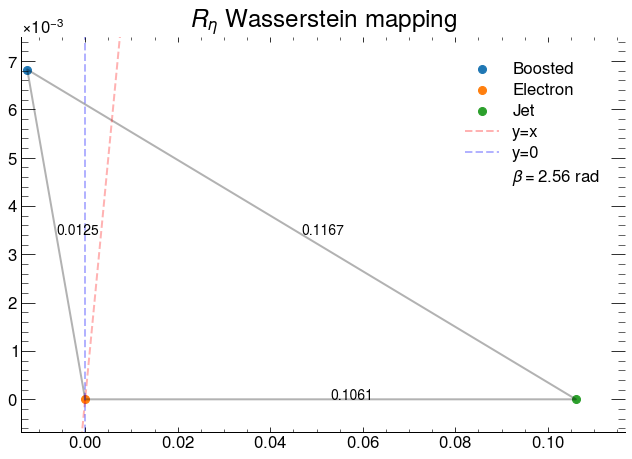

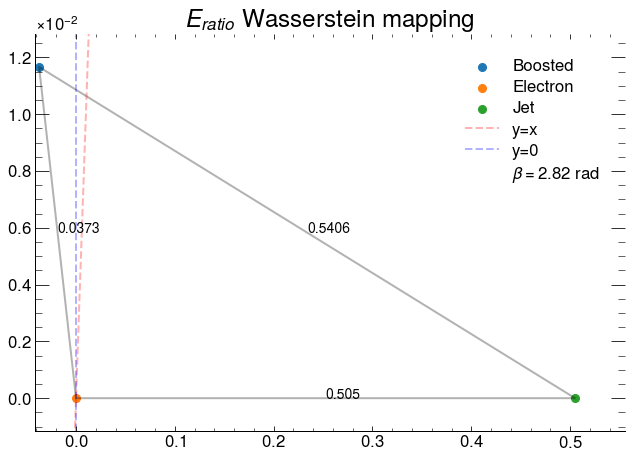

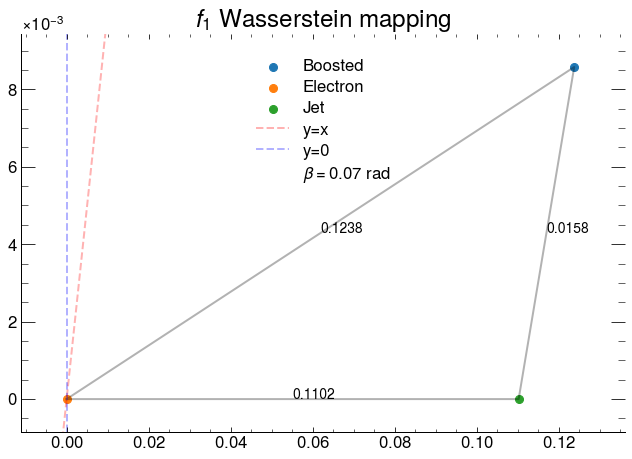

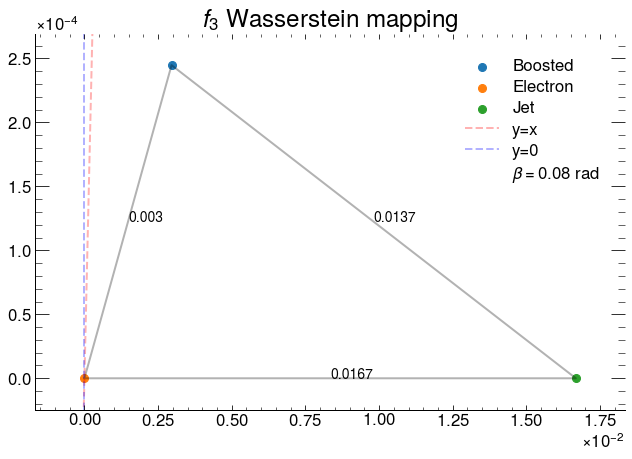

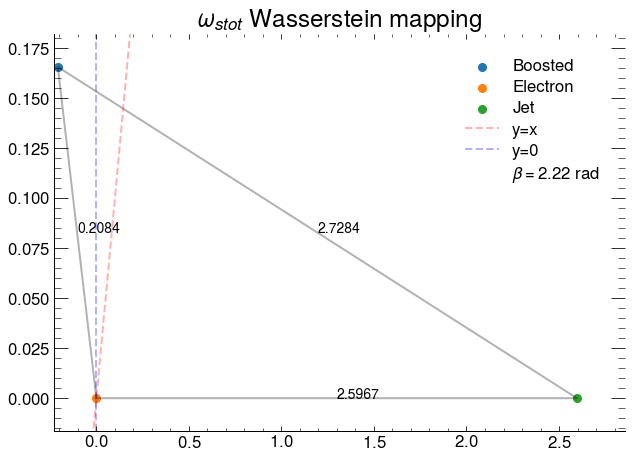

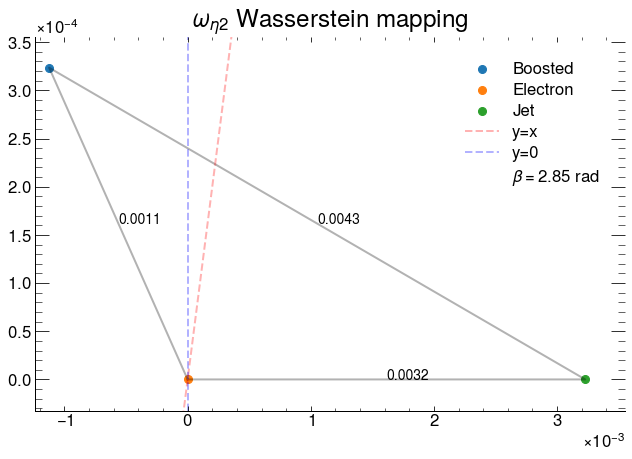

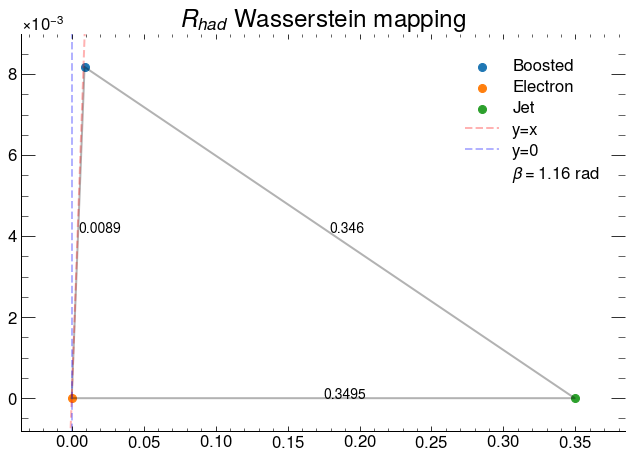

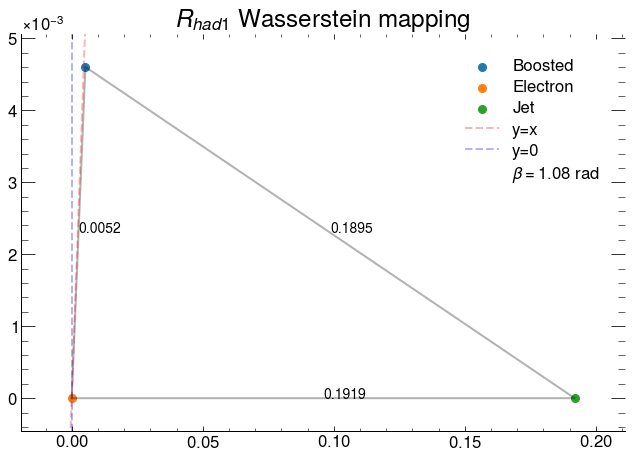

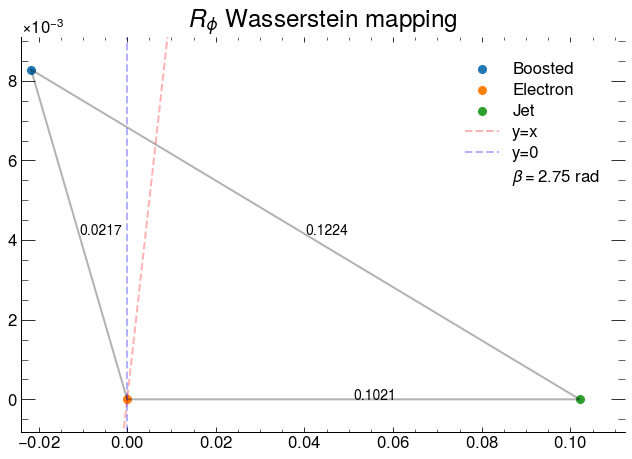

In [11]:
figs = dict()
electron = np.array((0,0))
for i, row_info in enumerate(wass_distances.iterrows()):
    fig, ax = plt.subplots(1,1, figsize=(9,6.6), dpi=72)
    ss_name, row = row_info
    jet = np.array((electron[0]+row['el_jet'], 0))
    boosted_x = row['boosted_el'] if row['beta'] < np.pi/2 else -row['boosted_el']
    boosted = np.array((electron[0] + boosted_x, row['boosted_height']))
    left_x = 0-(row['el_jet']*0.1) if row['beta'] < np.pi/2 else -row['boosted_el']*1.1
    right_x = max(row['el_jet'], row['boosted_el'])*1.1
    ax.plot([electron[0], boosted[0], jet[0], electron[0]], 
        [electron[1], boosted[1], jet[1], electron[1]], color='k', alpha=0.3)
    ax.annotate(str(round(row['boosted_el'], 4)), xy=(electron+boosted)/2)
    ax.annotate(str(round(row['boosted_jet'], 4)), xy=(jet+boosted)/2)
    ax.annotate(str(round(row['el_jet'], 4)), xy=(electron+jet)/2)
    ax.scatter([boosted[0]], [boosted[1]], label='Boosted', color='C0')
    ax.scatter([electron[0]], [electron[1]], label='Electron', color='C1')
    ax.scatter([jet[0]], [jet[1]], label='Jet', color='C2')
    ax.plot([-1,1],[-1,1], color='red', alpha=0.3, linestyle='--', label='y=x')
    ax.axvline(0, color='blue', alpha=0.3, linestyle='--', label='y=0')
    ax.scatter([1e6], [1e6], label=f'$\\beta = {round(row["beta"], 2)}$ rad', color='white')
    ax.set(ylim=(0-row['boosted_height']*0.1,row['boosted_height']*1.1), 
        xlim=(left_x,right_x),
        title=f'{var_infos.loc[ss_name, "label"]} Wasserstein mapping')
    if ss_name == 'f1':     # The default legend call caused legend overlapping
        ax.legend(loc=9)
    else:
        ax.legend()
    sns.despine(ax=ax)
    fig.tight_layout()
    fig.savefig(os.path.join(analysis_path, f'{ss_name}_wass_triangle.png'), 
        transparent=False, facecolor='white')
    figs[ss_name] = (fig, ax)